In [1]:
import pandas as pd
import requests
import numpy as np
from scipy.optimize import minimize
import math  # Asegúrate de tener esta importación para math.ceil

def Estimar2(fecha, duracion=4, incremento_pct=0, incremento_pct_meli=0, inicio_incremento_meli=0):
    class Reserva:
        def __init__(self, horaDesde, horaHasta):
            self.horaDesde = horaDesde
            self.horaHasta = horaHasta

    horarios = np.arange(10, 24, 0.5)
    horarioAux = np.arange(10, 25 - duracion, 1)
    horariosReservas = [(i, i + duracion) for i in horarioAux]

    def obtener_valores_por_fecha(fecha):
        url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTqP8Cc8coM8EqPpAHDiRtyX2sxd1gokCUCbR8erhVrs7O9hXXbW0oruGaZIDtXYvLAztNoLG645L0I/pub?output=csv"
        response = requests.get(url)
        assert response.status_code == 200, 'Error al descargar los datos'
        df = pd.read_csv(url)
        
        columna_fecha = None
        for col in df.columns:
            if df[col].iloc[0] == fecha:
                columna_fecha = col
                break
        
        if columna_fecha is None:
            return f"No se encontró la fecha {fecha}"
        
        valoresMeli = [int(valor) for valor in df[columna_fecha].dropna().tolist() if valor.isdigit()]

        valoresMeliIncrementados = [0]*len(valoresMeli)

        # Aplicar incremento a los valores de Meli desde el índice especificado
        for i in range(inicio_incremento_meli, len(valoresMeliIncrementados)):
            valoresMeliIncrementados[i] = math.ceil(valoresMeli[i] + valoresMeli[i] * incremento_pct_meli / 100)

        for i in range(0, inicio_incremento_meli):
            valoresMeliIncrementados[i] = valoresMeli[i]      


        return valoresMeli, valoresMeliIncrementados

    reservasMeli, valoresMeliIncrementados = obtener_valores_por_fecha(fecha)

    def calcular_disponibilidad(configuracion):
        reservas = [Reserva(horariosReservas[i][0], horariosReservas[i][1]) for i, cantidad in enumerate(configuracion) for _ in range(round(cantidad))]
        disponibilidad = [sum(1 for reserva in reservas if reserva.horaDesde <= hora and reserva.horaHasta > hora) for hora in horarios]
        return disponibilidad

    def objetivo(config):
        disponibilidad = calcular_disponibilidad(config)
        if len(valoresMeliIncrementados) != len(disponibilidad):
            raise ValueError("Error: diferentes largos entre listas de disponibilidad meli-rapiboy")
        return sum((rm - rd)**2 for rm, rd in zip(valoresMeliIncrementados, disponibilidad))

    valores_iniciales = [valoresMeliIncrementados[0]] * len(horariosReservas)
    bounds = [(valoresMeliIncrementados[0], None) for _ in range(len(valores_iniciales))]
    resultado_optimizacion = minimize(objetivo, valores_iniciales, method='Powell', bounds=bounds)
    configuracionOptima = [int(x) for x in resultado_optimizacion.x]

    # Aplicar el incremento porcentual y redondear hacia arriba
    configuracionIncrementada = [math.ceil(x + x * incremento_pct / 100) for x in configuracionOptima]

    Resultados = [{'horaDesde': f"{horariosReservas[i][0]:02d}:00", 'horaHasta': f"{horariosReservas[i][1]:02d}:00", 'cantidad': configuracionIncrementada[i]} for i in range(len(horariosReservas))]
    
    # Calcular la disponibilidad final usando la configuración incrementada
    disponibilidadFinal = calcular_disponibilidad(configuracionIncrementada)

    final = {
        "turnos": Resultados,
        "disponibilidadFinal": disponibilidadFinal,
        "necesidadesMeli": reservasMeli,
        "necesidadesMeliIncrementado": valoresMeliIncrementados
    }

    return final


In [2]:
from sqlalchemy import create_engine
from QueryReservasxHora import generarQuery

def RepasReales(fecha):

    server = '190.210.150.90,1433'
    database = 'rapiboyv7'
    username = 'gastonMichelotti'
    password = 'e4c9b81800490aab2c7ece08018853f23ac75e08ecb7725a6d6cb496539b3fe1'
    driver= 'ODBC Driver 17 for SQL Server'
    port= '1433'

    # Formulate the connection string for SQLAlchemy with pyodbc
    conn = f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}?driver={driver}"

    # Create an SQLAlchemy engine
    engine = create_engine(conn)

    query = generarQuery(fecha)

    result = pd.read_sql(query,engine)

    return result

In [3]:
import matplotlib.pyplot as plt

def graficar_resultados(resultado, reales, resultadooriginal = None):
    horarios = [f"{int(hora):02d}:{int((hora - int(hora)) * 60):02d}" for hora in np.arange(10, 24, 0.5)]
    disponibilidadFinal = resultado["disponibilidadFinal"]

    if resultadooriginal != None:
        disponibilidadOriginal = resultadooriginal["disponibilidadFinal"]
    necesidadesMeli = resultado["necesidadesMeli"]
    necesidadesMeliAumentado = resultado["necesidadesMeliIncrementado"]
    disponibilidadCargada = reales["TotalReservas"]
    disponibilidadReal = reales["ReservasConLlegada"]


    plt.figure(figsize=(15, 7))
    plt.plot(horarios, necesidadesMeli[:len(horarios)], label='Repartidores Solicitados por Meli', marker='D', color = 'green')
    # plt.plot(horarios, necesidadesMeliAumentado[:len(horarios)], label='Repartidores Solicitados por Meli Aumenado', marker='x', color = '#ff7c1f')
    plt.plot(horarios, disponibilidadFinal, label='Estimacion Repartidores fixeada', marker='o', color = '#0576ff')
    # plt.plot(horarios, disponibilidadOriginal, label='Disponibilidad Repartidores original', marker='p', color = '#003980')
    plt.plot(horarios, disponibilidadCargada, label='Repartidores Cargados ', marker='*', color = 'red')
    plt.plot(horarios, disponibilidadReal, label='Repartidores reales', marker='*', color = 'purple')
    plt.title('Disponibilidad vs. Solicitudes de Repartidores por Hora')
    plt.xlabel('Hora del Día')
    plt.ylabel('Cantidad de Repartidores')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def revisionMeli(fecha, duracion = 4, aumento = 0, aumentoDemanda = 0, aumentoDesde = 0, verbose = True):

    estimacion = Estimar2(fecha, duracion, aumento, aumentoDemanda,aumentoDesde)
    if verbose == True:
        print("Estimación Lista")

    # estimacion_original = Estimar2(fecha, duracion, 0, 0, 0)
    # if verbose == True:
    #     print("Estimación no fixeada Lista")

    reales = RepasReales(fecha)
    if verbose == True:
        print("Disponibilidad Real Lista")

    graficar_resultados(estimacion,reales)
    print( estimacion)
    

Estimación Lista
Disponibilidad Real Lista


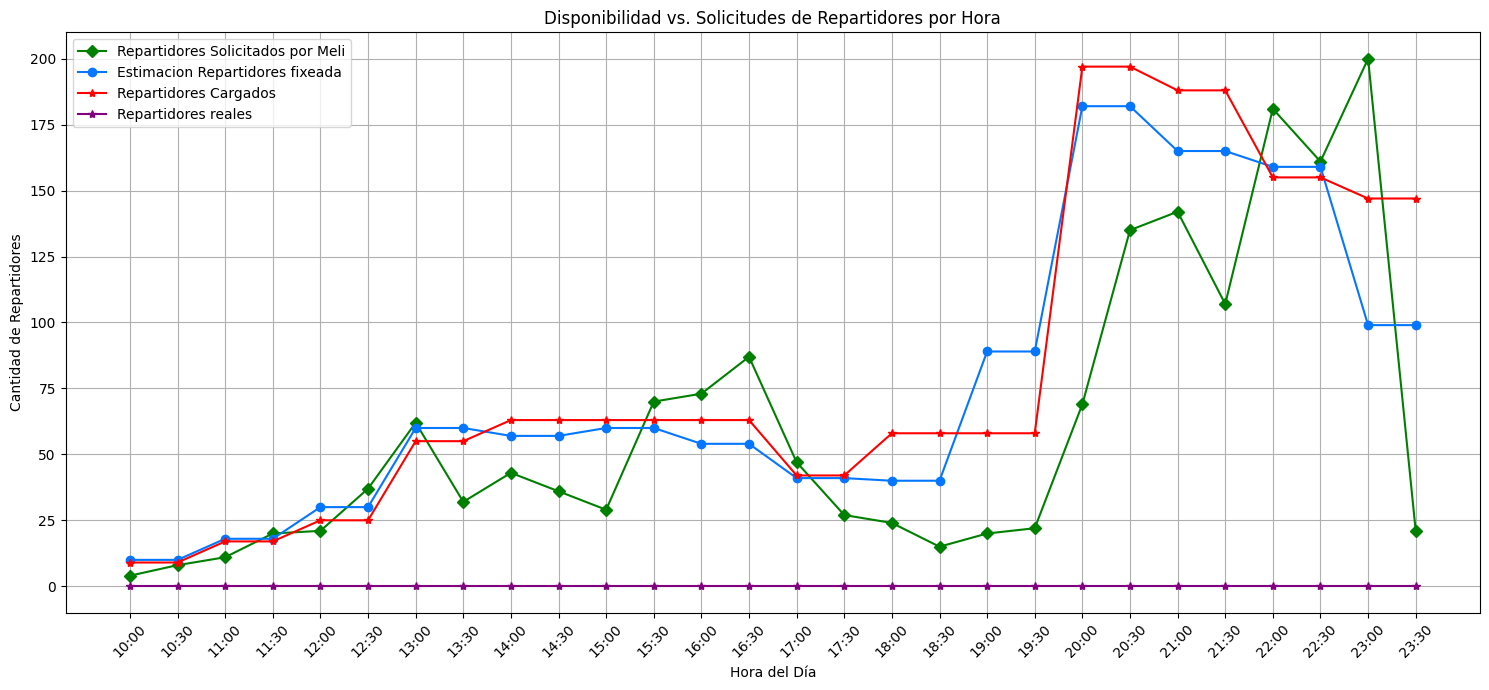

{'turnos': [{'horaDesde': '10:00', 'horaHasta': '14:00', 'cantidad': 10}, {'horaDesde': '11:00', 'horaHasta': '15:00', 'cantidad': 8}, {'horaDesde': '12:00', 'horaHasta': '16:00', 'cantidad': 12}, {'horaDesde': '13:00', 'horaHasta': '17:00', 'cantidad': 30}, {'horaDesde': '14:00', 'horaHasta': '18:00', 'cantidad': 7}, {'horaDesde': '15:00', 'horaHasta': '19:00', 'cantidad': 11}, {'horaDesde': '16:00', 'horaHasta': '20:00', 'cantidad': 6}, {'horaDesde': '17:00', 'horaHasta': '21:00', 'cantidad': 17}, {'horaDesde': '18:00', 'horaHasta': '22:00', 'cantidad': 6}, {'horaDesde': '19:00', 'horaHasta': '23:00', 'cantidad': 60}, {'horaDesde': '20:00', 'horaHasta': '24:00', 'cantidad': 99}], 'disponibilidadFinal': [10, 10, 18, 18, 30, 30, 60, 60, 57, 57, 60, 60, 54, 54, 41, 41, 40, 40, 89, 89, 182, 182, 165, 165, 159, 159, 99, 99], 'necesidadesMeli': [4, 8, 11, 20, 21, 37, 62, 32, 43, 36, 29, 70, 73, 87, 47, 27, 24, 15, 20, 22, 69, 135, 142, 107, 181, 161, 200, 21], 'necesidadesMeliIncrementado'

In [20]:
revisionMeli('25/02', 4, 5, 25, 24)

## LEGACY


In [ ]:
import pandas as pd
import requests
import numpy as np
from scipy.optimize import minimize
import json

def Estimar(fecha, duracion = 4):

    #Utilidades Estáticas
    class Reserva:
        # Constructor de la clase
        def __init__(self, horaDesde, horaHasta):
            # Atributo de la clase
            self.horaDesde = horaDesde
            self.horaHasta = horaHasta

    # Estos valores son parámetros que algun dia se pueden querer tocar
    horarios = np.arange(10, 24, 0.5)
    # horariosReservas = [(10,14), (12,16), (14.5, 18.5), (17, 20), (19,23), (20.5, 24)]  

    # Probando con todos los turnos posibles de 4 hs
    horarioAux = np.arange(10, 25 - duracion, 1)

    horariosReservas = []

    for i in range(len(horarioAux)):
        horariosReservas.append((horarioAux[i], horarioAux[i] + duracion))



    def obtener_valores_por_fecha(fecha):
        """Obtiene los valores de repas activos por hora que necesita Meli - desde un google sheets nuestro"""

        url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTqP8Cc8coM8EqPpAHDiRtyX2sxd1gokCUCbR8erhVrs7O9hXXbW0oruGaZIDtXYvLAztNoLG645L0I/pub?output=csv"
        response = requests.get(url)
        assert response.status_code == 200, 'Error al descargar los datos'
        df = pd.read_csv(url)
        
        # Encontrar la columna con la fecha dada
        columna_fecha = None
        for col in df.columns:
            if df[col].iloc[0] == fecha:
                columna_fecha = col
                break
        
        if columna_fecha is None:
            return f"No se encontró la fecha {fecha}"
        
        # Obtener los valores no nulos de esa columna
        valoresMeli = df[columna_fecha].dropna().tolist()

        # Convertir valores de string a integer
        valoresMeli = [int(valor) for valor in valoresMeli if valor.isdigit()]

        return valoresMeli  # Excluimos las primeras dos filas que son encabezados

    def calcular_disponibilidad(configuracion):
        """En Base a la cantidad de reservas por turno pre armado, calcula la disponibilidad de repas"""   

        if duracion == 4:
            [A, B, C, D, E, F, G, H, I, J, K]= configuracion        
        else: 
            #ASUME 3 HS
            [A, B, C, D, E, F, G, H, I, J, K, L ]= configuracion   

        
        reservas = []

        for i in range(len(configuracion)):

            cantidad = round(configuracion[i])

            for j in range(cantidad):
                reservas.append(Reserva(horariosReservas[i][0], horariosReservas[i][1]))

        disponibilidad = []

        for i in horarios:
            contador = 0

            for reserva in reservas:
                if reserva.horaDesde <= i and reserva.horaHasta > i:
                    contador += 1
            
            disponibilidad.append(contador)
                
        return disponibilidad
            

    reservasMeli = obtener_valores_por_fecha(fecha)

    # Función objetivo para la optimización
    def objetivo(config):

        disponibilidad = calcular_disponibilidad(config)
        
        if len(reservasMeli) != len(disponibilidad):
            raise ValueError("Error: diferentes largos entre listas de disponibilidad meli-rapiboy")
        
        diferencia = sum((rm - rd)**2 for rm, rd in zip(reservasMeli, disponibilidad))
        
        # diferencia = 0

        # for i in range(len(reservasMeli)):
        #     diferencia += (reservasMeli[i] -  disponibilidad[i])**2
        
        return diferencia  


    # Valores iniciales para los precios
    # valores_iniciales = [reservasMeli[0], reservasMeli[8],reservasMeli[13], reservasMeli[18], reservasMeli[22], reservasMeli[23]]
    valores_iniciales = [reservasMeli[0]]* len(horariosReservas)

    # Definir los límites para cada parámetro en config
    # (0, None) significa que el valor puede variar de 0 a infinito
    bounds = [(reservasMeli[0], None) for _ in range(len(valores_iniciales))]

    # Llamada a minimize con opciones adicionales
    resultado_optimizacion = minimize(objetivo, valores_iniciales, method='Powell', bounds=bounds)

    # Resultados óptimos
    configuracionOptima = resultado_optimizacion.x   

    Resultados = []

    for i in range(len(horariosReservas)):
        configuracionOptima[i] = int(configuracionOptima[i])

        # resultado = (f"{horariosReservas[i][0]:02d}:00", f"{horariosReservas[i][1]:02d}:00", int(configuracionOptima[i]))
        # Resultados.append(resultado)

        Resultados.append({
        'horaDesde': f"{horariosReservas[i][0]:02d}:00", 
        'horaHasta': f"{horariosReservas[i][1]:02d}:00", 
        'cantidad': int(configuracionOptima[i])})

    final = {"turnos" : Resultados}

    return final

